<a href="https://colab.research.google.com/github/orihers/gym-minigrid/blob/master/mini_grip_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Used resources: 
https://wang.works/portfolio/code/Reinforcement-Learning-Policy-Gradient-Methods.html

https://github.com/maximecb/gym-minigrid



In [2]:
# Add utils here

import glob
import io
import base64
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from IPython.display import HTML
from IPython import display as ipythondisplay


"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def count_model_params(model):
    return sum(p.numel() for p in model.parameters())


def plot_std_learning_curves(rewards, success_rates, num_it, no_show=False):
    r, sr = np.asarray(rewards), np.asarray(success_rates)
    df = pd.DataFrame(r).melt()
    sns.lineplot(x="variable", y="value", data=df, label='reward/eps')
    df = pd.DataFrame(sr).melt()
    sns.lineplot(x="variable", y="value", data=df, label='success rate')
    plt.xlabel("Training iterations")
    plt.ylabel("")
    plt.xlim([0, num_it])
    plt.ylim([0, 1])
    plt.legend()
    plt.grid('on')
    if not no_show:
        plt.show()


def plot_learning_curve(rewards, success_rate, num_it, plot_std=False):
    if plot_std:
        # plots shaded regions if list of reward timeseries is given
        plot_std_learning_curves(rewards, success_rate, num_it)
    else:
        plt.plot(rewards, label='reward/eps')
        if success_rate:
            plt.plot(success_rate, label='success rate')
            plt.legend()
        else:
            plt.ylabel('return / eps')
        plt.ylim([0, 1])
        plt.xlim([0, num_it - 1])
        plt.xlabel('train iter')
        plt.grid('on')
        plt.show()

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

# Wrapper around dictionary that enables attribute access instead of the bracket syntax
# i.e. you can replace d['item'] with d.item
class ParamDict(dict):
    __setattr__ = dict.__setitem__
    def __getattr__(self, attr):
        # Take care that getattr() raises AttributeError, not KeyError.
        # Required e.g. for hasattr(), deepcopy and OrderedDict.
        try:
            return self.__getitem__(attr)
        except KeyError:
            raise AttributeError("Attribute %r not found" % attr)
    def __getstate__(self): return self
    def __setstate__(self, d): self = d

# Policy Gradient with gym-MiniGrid
> In this session, it will show the pytorch-implemented Policy Gradient in Gym-MiniGrid Environment.  Through this, you will know how to implement Vanila Policy Gradient (also known as REINFORCE), and test it on open source RL environment.

## Basic Jupyter Setting

In [3]:
import tensorflow as tf

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Setup the environment
Gridworld is widely used in RL environment. [Gym-MiniGrid](https://github.com/maximecb/gym-minigrid) is custom GridWorld environment of OpenAI [gym](https://github.com/openai/gym) style. Before dive in this environment, you need to install both of them.
```
pip install gym
pip install gym-minigrid 
```
At first, Let's look at some frames of MiniGrid.

In [5]:
!pip install gym
!pip install gym-minigrid

     |████████████████████████████████| 47 kB 4.3 MB/s 


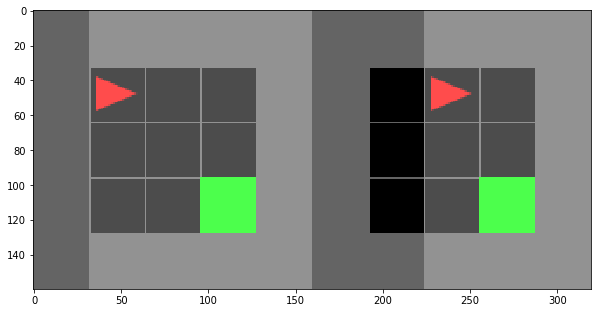

In [6]:
import gym
import gym_minigrid

env = gym.make('MiniGrid-Empty-5x5-v0')
env.reset()
before_img = env.render('rgb_array')
action = env.actions.forward
obs, reward, done, info = env.step(action)
after_img = env.render('rgb_array')

plt.imshow(np.concatenate([before_img, after_img], 1));

This is the example of `MiniGrid-Empty-5x5-v0` environment. There are some blank cells, and gray obstacle which the agent cannot pass it. And the green cell is the goal to reach. The ultimate goal of this environment (and most of RL problem) is to find the optimal policy with highest reward. In this case, well-trained agent should find the optimal path to reach the goal.

Let's move to more larger environment `MiniGrid-Empty-8x8-v0`, and find the information what we can get.

Observation: {'image': array([[[2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]]], dtype=uint8), 'direction': 1, 'm

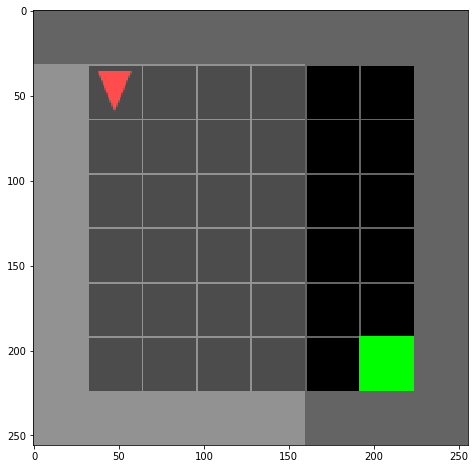

In [7]:
# Make a new environment MiniGrid-Empty-8x8-v0
env = gym.make('MiniGrid-Empty-8x8-v0')

# Reset the environment
env.reset()

# Select the action right (sample action)
action = env.actions.right

# Take a step in the environment and store it in appropriate variables
obs, reward, done, info = env.step(action)

# Render the current state of the environment
img = env.render('rgb_array')

print('Observation:', obs)
print('Reward:', reward)
print('Done:', done)
print('Info:', info)
print('Image shape:', img.shape)
plt.imshow(img);

As the agent take an action, environment (MiniGrid) will be changed with respect to action. 
If the agent want to find the optimal path, the agent should notice the difference between current state and next state while taking an action. To help this, the environment generates next state, reward, and terminal flags.

To help agent training easily, MiniGrid offers `FlatObsWrapper` for flattening observation (in other words, 1D array)

In [8]:
import gym
from gym import spaces
from gym_minigrid.minigrid import OBJECT_TO_IDX, COLOR_TO_IDX

max_env_steps = 50

class FlatObsWrapper(gym.core.ObservationWrapper):
    """Fully observable gridworld returning a flat grid encoding."""

    def __init__(self, env):
        super().__init__(env)

        # Since the outer walls are always present, we remove left, right, top, bottom walls
        # from the observation space of the agent. There are 3 channels, but for simplicity
        # in this assignment, we will deal with flattened version of state.
        
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=((self.env.width-2) * (self.env.height-2) * 3,),  # number of cells
            dtype='uint8'
        )
        self.unwrapped.max_steps = max_env_steps

    def observation(self, obs):
        # this method is called in the step() function to get the observation
        # we provide code that gets the grid state and places the agent in it
        env = self.unwrapped
        full_grid = env.grid.encode()
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
            OBJECT_TO_IDX['agent'],
            COLOR_TO_IDX['red'],
            env.agent_dir
        ])
        full_grid = full_grid[1:-1, 1:-1]   # remove outer walls of the environment (for efficiency)
        
        flattened_grid = full_grid.ravel()
        return flattened_grid
    
    def render(self, *args, **kwargs):
        """This removes the default visualization of the partially observable field of view."""
        kwargs['highlight'] = False
        return self.unwrapped.render(*args, **kwargs)

In [9]:
class FullyObsWrapper(gym.core.ObservationWrapper):
    """
    Fully observable gridworld using a compact grid encoding
    """

    def __init__(self, env):
        super().__init__(env)

        self.observation_space.spaces["image"] = spaces.Box(
            low=0,
            high=255,
            shape=(self.env.width, self.env.height, 3),  # number of cells
            dtype='uint8'
        )

    def observation(self, obs):
        env = self.unwrapped
        full_grid = env.grid.encode()
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
            OBJECT_TO_IDX['agent'],
            COLOR_TO_IDX['red'],
            env.agent_dir
        ])

        return {
            'mission': obs['mission'],
            'image': full_grid
        }

So It's time to run with sample action!

Observation: [10  0  1  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0
  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0
  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0
  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0
  1  0  0  1  0  0  1  0  0  8  1  0] , Observation Shape:  (108,)
Reward: 0
Done: False
Info: {}
Image shape: (256, 256, 3)


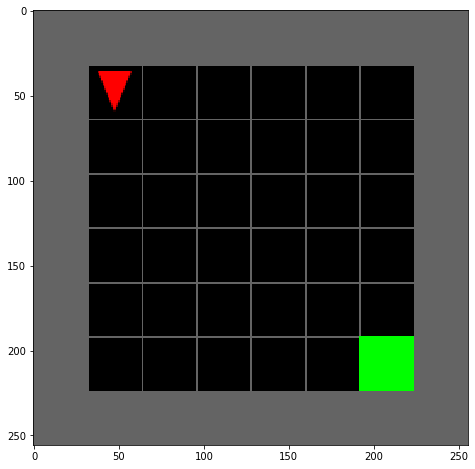

In [10]:
# Convert MiniGrid Environment with Flat Observable 
env = FlatObsWrapper(gym.make('MiniGrid-Empty-8x8-v0'))

# Reset the environment
env.reset()

# Select the action right
action = env.actions.right

# Take a step in the environment and store it in appropriate variables
obs, reward, done, info = env.step(action)

# Render the current state of the environment
img = env.render('rgb_array')
################# YOUR CODE ENDS HERE ###############################

print('Observation:', obs, ', Observation Shape: ', obs.shape)
print('Reward:', reward)
print('Done:', done)
print('Info:', info)
print('Image shape:', img.shape)
plt.imshow(img);

As you can see it in observation, the dimension of observation is changed from 2D to 1D. Using this observation, we will make some kind of neural network to help agent to notice the observation. Let's check the real-time video of random movement.

In [11]:
from gym.wrappers import Monitor

# Monitor is a gym wrapper, which helps easy rendering of videos of the wrapped environment.
def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

# class CustomEnv(gym.Env):
#     def __init__(self, env_name):
#         super(CustomEnv, self).__init__()

#     def manhattan_distance(self, x, y):
#         distance = np.sum(np.abs(x-y))
#         return distance

    
def gen_wrapped_env(env_name, custom=False):
    return wrap_env(FlatObsWrapper(gym.make(env_name)))

Currently, OpenAI Gym offers several utils to help understanding the training progress. Monitor is one of that tool to log the history data. If we set the rendering option to `rgb_array`, the video data will be stored in specific path. (Maybe it requires some additional apps such as ffmpeg)

## Test with Random Policy

In [12]:
# Random agent - we only use it in this cell for demonstration
class RandPolicy:
    def __init__(self, action_space):
        self.action_space = action_space
        
    def act(self, *unused_args):
        return self.action_space.sample(), None

At first, we want check the operation of environment-agent interaction. To do this, Random Policy that generates the "random action" is defined. This policy just generates random action from pre-defined action space. And then run it. 
> Note that `pytorch_policy` flag is set to `False` as a default. But to implement the policy gradient, the gradient calculation is required, and pytorch will be used.

In [13]:
# This function plots videos of rollouts (episodes) of a given policy and environment
def log_policy_rollout(policy, env_name, pytorch_policy=False):
    # Create environment with flat observation
    env = gen_wrapped_env(env_name, True)

    # Initialize environment
    observation = env.reset()

    done = False
    episode_reward = 0
    episode_length = 0

    # Run until done == True
    while not done:
      # Take a step
        if pytorch_policy: 
            observation = torch.tensor(observation, dtype=torch.float32)
            action = policy.act(observation)[0].data.cpu().numpy()
        else:
            action = policy.act(observation)[0]
        observation, reward, done, info = env.step(action)

        episode_reward += reward
        episode_length += 1

    print('Total reward:', episode_reward)
    print('Total length:', episode_length)

    env.close()
    
    show_video()

# Test that the logging function is working
test_env_name = 'MiniGrid-Empty-8x8-v0'
rand_policy = RandPolicy(FlatObsWrapper(gym.make(test_env_name)).action_space)
log_policy_rollout(rand_policy, test_env_name)

Total reward: 0
Total length: 50


That's the agent work with Random Policy. We found out that Random Policy is not optimal policy since the agent (the red one) cannot reach the goal.(or maybe it'll reach the goal after infinite times go on...)  So to reach the goal, it requires more intelligent policy. In natural sense of mind, it needs,

- Remember the previous trajectory
- When it goes to unknown cell, based on the experience with memory, use it to find the way to goal

## Implement Rollout Buffer
Before implementing Policy Gradient, it requires to implement memory object to store the previous trajectory or information offered from environment. Sometimes, it is called "Replay Buffer" or "Rollout Buffer", but in this page, RolloutBuffer will be used for expression. To implement Rollout Buffer, we need to consider such that,

- how many trajectories stored in buffer?
- how to add trajectory into the buffer?
- (In view of Reinforcement Learning) how to calculate the future reward based on previous reward
- (+) how to sample the trajectory efficiently?

So this is RolloutBuffer implementation!

In [14]:
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

class RolloutBuffer():
    def __init__(self, rollout_size, obs_size):
        self.rollout_size = rollout_size
        self.obs_size = obs_size
        self.reset()
        
    def insert(self, step, done, action, log_prob, reward, obs):    
        self.done[step].copy_(done)
        self.actions[step].copy_(action)
        self.log_probs[step].copy_(log_prob)
        self.rewards[step].copy_(reward)
        self.obs[step].copy_(obs)
        
    def reset(self):
        self.done = torch.zeros(self.rollout_size, 1)
        self.returns = torch.zeros(self.rollout_size + 1, 1, requires_grad=False)
        # Assuming Discrete Action Space
        self.actions = torch.zeros(self.rollout_size, 1, dtype=torch.int64)  
        self.log_probs = torch.zeros(self.rollout_size, 1)
        self.rewards = torch.zeros(self.rollout_size, 1)
        self.obs = torch.zeros(self.rollout_size, self.obs_size)
        
    def compute_returns(self, gamma):
        # Compute Returns until the last finished episode
        self.last_done = (self.done == 1).nonzero().max()  
        self.returns[self.last_done + 1] = 0.

        # Accumulate discounted returns
        for step in reversed(range(self.last_done + 1)):
            self.returns[step] = self.returns[step + 1] * \
                gamma * (1 - self.done[step]) + self.rewards[step]
        
    def batch_sampler(self, batch_size, get_old_log_probs=False):
        sampler = BatchSampler(
            SubsetRandomSampler(range(self.last_done)),
            batch_size,
            drop_last=True)
        for indices in sampler:
            if get_old_log_probs:
                yield self.actions[indices], self.returns[indices], self.obs[indices], self.log_probs[indices]
            else:
                yield self.actions[indices], self.returns[indices], self.obs[indices]

There are couple of things to notice that,

- All information stored in RolloutBuffer should get the type of `torch.Tensor`
- In this case, returns will be used for minimizing the loss. So returns object should set the `requires_grad` to `True`
- It is inefficient to use all information to train the policy. To handle it, it requires something special sampling strategy. In this code, `BatchSample` is used.

## Construct Policy Network

Now that we can store rollouts we need a policy to collect them. In the following you will complete the provided base code for the policy class. The policy is instantiated as a small neural network with simple fully-connected layers, the `ActorNetwork`. The role of policy is sort of strategy that generates the action. (Actually, it is just the probability to generate the action).
 And Of course, the important work through `ActorNetwork` is to update policy per each iteration. With pytorch, we need to define,
 
- What optimizer should we use?
- How can we define the loss function?

At first, Let's look gradient function used in policy gradient,

$$ \nabla J(\theta) = \mathbb{E}_{\pi}\big[ \nabla_{\theta} \log \pi_{\theta}(a, s) \; V_t(s) \big] $$

Here, $\theta$ are the parameters of the policy network $\pi_{\theta}$ and $V_t(s)$ is the observed future discounted reward from state $s$ onwards which should be **maximized** (we need to focus on this keyword, since the purpose of neural network training is to **minimize** the loss, not **maximize**). So anyway we need the calculate the gradient of $\log \pi_{\theta}(a, s)$ and calculate its mean.

And Plus, there are some approaches to enhance the exploration. If we can consider the **entropy loss** to handle the overall loss, it takes diverse action. At that case gradient fuction will be,

$$ \nabla J(\theta) = \mathbb{E}_{\pi}\big[ \nabla_{\theta} \log \pi_{\theta}(a, s) \; V_t(s) \big] + \nabla_{\theta}\mathcal{H}\big[\pi_\theta(a, s)\big]$$

And here is the implementation of Actor Network (and it's quite simple!)

In [15]:
import torch
import torch.nn as nn

class ActorNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim):
        super().__init__()
        self.num_actions = num_actions
        
        # Works Nice
        self.fc = nn.Sequential(
            nn.Linear(num_inputs, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_actions)
        )

        # Another try - not working properly
        # self.fc = nn.Sequential(
        #     nn.Linear(num_inputs, 24),
        #     nn.ReLU(),
        #     nn.Linear(24, num_actions)
        # )
        
    def forward(self, state):
        x = self.fc(state)
        return x

And Below is the implementation of Policy. We select the Adam Optimizer 

In [16]:
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.categorical import Categorical

class Policy():
    def __init__(self, num_inputs, num_actions, hidden_dim, learning_rate,
                 batch_size, policy_epochs, moreParams=False, entropy_coef=0.001):

        self.actor = ActorNetwork(num_inputs, num_actions, hidden_dim)
        
        self.optimizer = optim.Adam(self.actor.parameters(), lr=learning_rate)
        self.batch_size = batch_size
        self.policy_epochs = policy_epochs
        self.entropy_coef = entropy_coef

    def act(self, state):
        logits = self.actor(state)
        # To generate the probability of action, we assume its state has categorical distribution.
        dist = Categorical(logits=logits)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action, log_prob
    
    def evaluate_actions(self, state, action):
        logits = self.actor(state)
        dist = Categorical(logits=logits)
        log_prob = dist.log_prob(action.squeeze(-1)).view(-1, 1)
        entropy = dist.entropy().view(-1, 1)
        return log_prob, entropy
    
    def update(self, rollouts):
        for epoch in range(self.policy_epochs):
            data = rollouts.batch_sampler(self.batch_size)
            
            for sample in data:
                actions_batch, returns_batch, obs_batch = sample
    
                log_probs_batch, entropy_batch = self.evaluate_actions(obs_batch, actions_batch)
    
                # Compute the mean loss for the policy update using 
                # action log-probabilities and policy returns
                policy_loss = -(log_probs_batch * returns_batch).mean()
                # Compute the mean entropy for the policy update 
                entropy_loss = -entropy_batch.mean()
                
                loss = policy_loss + self.entropy_coef * entropy_loss
                
                self.optimizer.zero_grad()
                loss.backward(retain_graph=False)
                self.optimizer.step()
                
    @property
    def num_params(self):
        return count_model_params(self.actor)

In [17]:
from IPython.display import clear_output
import time

def train(env, rollouts, policy, params, seed=123):
    # SETTING SEED: it is good practice to set seeds when running experiments to keep results comparable
    np.random.seed(seed)
    torch.manual_seed(seed)
    env.seed(seed)

    rollout_time, update_time = AverageMeter(), AverageMeter()  # Loggers
    rewards, success_rate = [], []

    print("Training model with {} parameters...".format(policy.num_params))

    # Training Loop
    for j in range(params.num_updates):
        ## Initialization
        avg_eps_reward, avg_success_rate = AverageMeter(), AverageMeter()
        done = False
        prev_obs = env.reset()
        prev_obs = torch.tensor(prev_obs, dtype=torch.float32)
        eps_reward = 0.
        start_time = time.time()
        
        ## Collect rollouts
        for step in range(rollouts.rollout_size):
            if done:
                # Store episode statistics
                avg_eps_reward.update(eps_reward)
                if 'success' in info: 
                    avg_success_rate.update(int(info['success']))

                # Reset Environment
                obs = env.reset()
                obs = torch.tensor(obs, dtype=torch.float32)
                eps_reward = 0.
            else:
                obs = prev_obs

            action, log_prob = policy.act(obs)
            obs, reward, done, info = env.step(action)
            # if action == 2:
            #     reward +=0.03

            rollouts.insert(step, torch.tensor(done, dtype=torch.float32), action, log_prob, 
                            torch.tensor(reward, dtype=torch.float32), 
                            prev_obs)
            
            prev_obs = torch.tensor(obs, dtype=torch.float32)
            eps_reward += reward
        
        # Use the rollout buffer's function to compute the returns for all stored rollout steps. (requires just 1 line)
        rollouts.compute_returns(params['discount'])
        
        rollout_done_time = time.time()

        
        # Call the policy's update function using the collected rollouts        
        policy.update(rollouts)

        update_done_time = time.time()
        rollouts.reset()

        ## log metrics
        rewards.append(avg_eps_reward.avg)
        if avg_success_rate.count > 0:
            success_rate.append(avg_success_rate.avg)
        rollout_time.update(rollout_done_time - start_time)
        update_time.update(update_done_time - rollout_done_time)
        print('it {}: avgR: {:.3f} -- rollout_time: {:.3f}sec -- update_time: {:.3f}sec'.format(j, 
                                                                                                avg_eps_reward.avg, 
                                                                                                rollout_time.avg,
                                                                                                update_time.avg))
        if j % params.plotting_iters == 0 and j != 0:
            #plot_learning_curve(rewards, success_rate, params.num_updates)
            log_policy_rollout(policy, params.env_name, pytorch_policy=True)
    clear_output()   # this removes all training outputs to keep the notebook clean, DON'T REMOVE THIS LINE!
    return rewards, success_rate

In [18]:
import copy

def instantiate(params_in, nonwrapped_env=None):
    params = copy.deepcopy(params_in)

    if nonwrapped_env is None:
        nonwrapped_env = gym.make(params.env_name)

    env = None
    env = FlatObsWrapper(nonwrapped_env)    
    obs_size = env.observation_space.shape[0]
    num_actions = env.action_space.n

    rollouts = RolloutBuffer(params.rollout_size, obs_size)
    policy_class = params.policy_params.pop('policy_class')
    
    policy = policy_class(obs_size, num_actions, **params.policy_params)
    return env, rollouts, policy

In [19]:
# hyperparameters
policy_params = ParamDict(
    policy_class = Policy,    # Policy class to use (replaced later)     
    hidden_dim = 32,          # dimension of the hidden state in actor network
    learning_rate = 1e-3,     # learning rate of policy update
    batch_size = 1024,        # batch size for policy update
    policy_epochs = 4,        # number of epochs per policy update
    entropy_coef = 0.001,     # hyperparameter to vary the contribution of entropy loss
)
params = ParamDict(
    policy_params = policy_params,
    rollout_size = 2050,      # number of collected rollout steps per policy update
    num_updates = 10,         # number of training policy iterations
    discount = 0.99,          # discount factor
    plotting_iters = 10,      # interval for logging graphs and policy rollouts
    env_name = 'MiniGrid-Empty-5x5-v0',  # we are using a tiny environment here for testing
)

In [20]:
env, rollouts, policy = instantiate(params)
rewards, success_rate = train(env, rollouts, policy, params)
print("Training completed!")

Training completed!


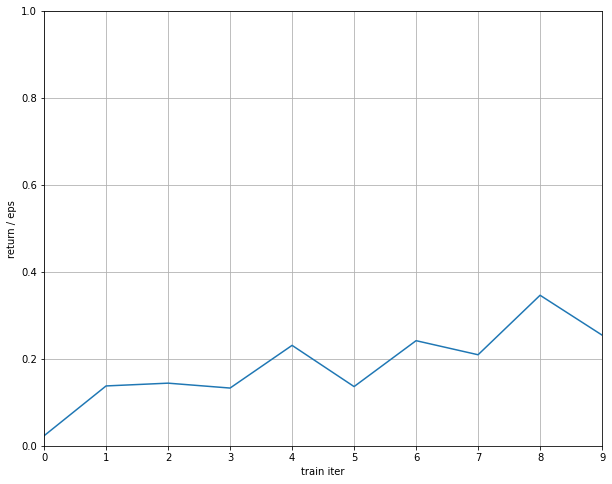

Total reward: 0
Total length: 50


In [21]:
# final reward + policy plotting for easier evaluation
plot_learning_curve(rewards, success_rate, params.num_updates)
for _ in range(1):
    log_policy_rollout(policy, params.env_name, pytorch_policy=True)

Training completed!


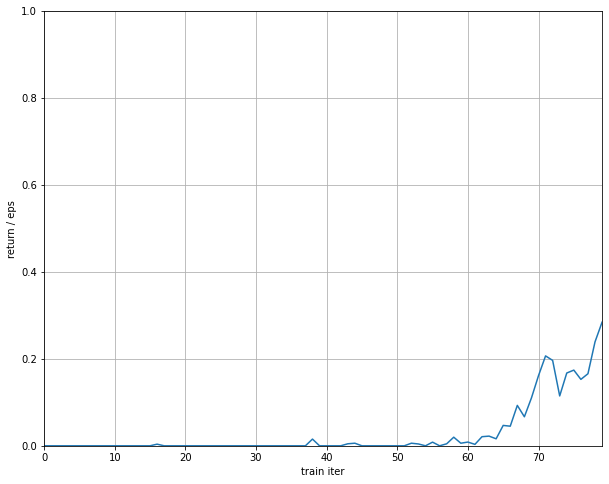

Total reward: 0.694
Total length: 17


In [22]:
# hyperparameters
policy_params = ParamDict(
    policy_class = Policy,    # Policy class to use (replaced later)     
    hidden_dim = 32,          # dimension of the hidden state in actor network
    learning_rate = 1e-3,     # learning rate of policy update
    batch_size = 1024,        # batch size for policy update
    policy_epochs = 4,        # number of epochs per policy update
    entropy_coef = 0.001,     # hyperparameter to vary the contribution of entropy loss
)
params = ParamDict(
    policy_params = policy_params,
    rollout_size = 2050,      # number of collected rollout steps per policy update
    num_updates = 80,         # number of training policy iterations
    discount = 0.99,          # discount factor
    plotting_iters = 10,      # interval for logging graphs and policy rollouts
    env_name = 'MiniGrid-Empty-8x8-v0',  # we are using a tiny environment here for testing
)

env, rollouts, policy = instantiate(params)
rewards, success_rate = train(env, rollouts, policy, params)
print("Training completed!")

# final reward + policy plotting for easier evaluation
plot_learning_curve(rewards, success_rate, params.num_updates)
for _ in range(1):
    log_policy_rollout(policy, params.env_name, pytorch_policy=True)

#Now lets mode to the Lava env

In [23]:
class CriticNetwork(nn.Module):
    def __init__(self, num_inputs, hidden_dim):
        super().__init__()

        ####################################################################################
        ### 1. Build the Actor network as a torch.nn.Sequential module                   ###
        ###    with the following layers:                                                ###
        ###        (1) a Linear layer mapping from input dimension to hidden dimension   ###
        ###        (2) a Tanh non-linearity                                              ###
        ###        (3) a Linear layer mapping from hidden dimension to hidden dimension  ###
        ###        (4) a Tanh non-linearity                                              ###
        ###        (5) a Linear layer mapping from hidden dimension to appropriate       ###
        ###            dimension                                                         ###
        ### Note: We do not need an activation on the output, because the actor is       ###
        ###       predicting a value, which can be any real number                       ###
        ####################################################################################
        self.fc = nn.Sequential( 
                   nn.Linear(num_inputs, 24),
                   nn.ReLU(),
                   nn.Linear(hidden_dim,1),

                 )

    def forward(self, state):
        x = self.fc(state)
        return x


class ACPolicy(Policy):
    def __init__(self, num_inputs, num_actions, hidden_dim, learning_rate, batch_size, policy_epochs,
                 entropy_coef=0.001, critic_coef=0.5):
        super().__init__(num_inputs, num_actions, hidden_dim, learning_rate, batch_size, policy_epochs, entropy_coef)

        self.critic = CriticNetwork(num_inputs, hidden_dim)
        
        ####################################################################################
        ### Create a common optimizer for actor and critic with the given learning rate  ###
        ### (requires 1-line of code)                                                    ###
        ####################################################################################
        self.optimizer = optim.Adam(self.actor.parameters(), lr=learning_rate)
        
        self.critic_coef = critic_coef
        
    def update(self, rollouts):   
        print_vals=0
        for epoch in range(self.policy_epochs):
            data = rollouts.batch_sampler(self.batch_size)
            
            for sample in data:
                actions_batch, returns_batch, obs_batch = sample
                log_probs_batch, entropy_batch = self.evaluate_actions(obs_batch, actions_batch)

                value_batch = self.critic(obs_batch)
                advantage = returns_batch - value_batch.detach()

                ####################################################################################
                ### 1. Compute the mean loss for the policy update using action log-             ###
                ###     probabilities and advantages.                                            ###
                ### 2. Compute the mean entropy for the policy update                            ###
                ### 3. Compute the critic loss as MSE loss between estimated value and expected  ###
                ###     returns.                                                                 ###
                ####################################################################################
                policy_loss = torch.mean(torch.sum(torch.mul(log_probs_batch.mul(-1), advantage), -1))
                entropy_loss = torch.mean(entropy_batch).mul(-1) #/self.batch_size
     
                critic_loss = F.mse_loss(returns_batch,value_batch)
        
                loss = policy_loss + \
                        self.critic_coef * critic_loss + \
                        self.entropy_coef * entropy_loss


                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
    @property
    def num_params(self):
        return super().num_params + count_model_params(self.critic)

In [24]:
class PPO(ACPolicy):       
    def update(self, rollouts): 
        self.clip_param = 0.2
        for epoch in range(self.policy_epochs):
            data = rollouts.batch_sampler(self.batch_size, get_old_log_probs=True)
            
            for sample in data:
                actions_batch, returns_batch, obs_batch, old_log_probs_batch = sample
                log_probs_batch, entropy_batch = self.evaluate_actions(obs_batch, actions_batch)
                
                value_batch = self.critic(obs_batch)
                
                advantage = returns_batch - value_batch.detach()
                old_log_probs_batch = old_log_probs_batch.detach()

                ratio = torch.exp(log_probs_batch.sub(old_log_probs_batch))
                surr1 = ratio.mul(advantage)
                surr2 = torch.clamp(ratio, min=1-self.clip_param, max=1+self.clip_param).mul(advantage)
                
                policy_loss = torch.mean(-torch.min(surr1,surr2))
                entropy_loss = torch.mean(entropy_batch).mul(-1) 
                critic_loss = F.mse_loss(returns_batch,value_batch)
     

                loss = policy_loss + \
                        self.critic_coef * critic_loss + \
                        self.entropy_coef * entropy_loss

                self.optimizer.zero_grad()
                loss.backward(retain_graph=False)
                self.optimizer.step()

In [25]:
# class CustomEnv(gym.make('MiniGrid-LavaGapS6-v0')):
#     def manhattan_distance(self, x, y):
#         distance = np.sum(np.abs(x-y))
#         return distance

In [27]:
# hyperparameters
n_seeds = 2
policy_params = ParamDict(
    policy_class = Policy,  # Policy class to use (replaced later)
    hidden_dim = 32,          # dimension of the hidden state in actor network
    learning_rate = 1e-3,     # learning rate of policy update
    batch_size = 1024,        # batch size for policy update
    policy_epochs = 4,        # number of epochs per policy update
    entropy_coef = 0.001,     # hyperparameter to vary the contribution of entropy loss
    # critic_coef = 0.5         # Coefficient of critic loss when weighted against actor loss
)
params = ParamDict(
    policy_params = policy_params,
    rollout_size = 2050,      # number of collected rollout steps per policy update
    num_updates = 3000,        # number of training policy iterations
    discount = 0.99,          # discount factor
    plotting_iters = 300,      # interval for logging graphs and policy rollouts
    env_name = 'MiniGrid-LavaGapS6-v0',  # we are using a tiny environment here for testing
)

rewards, success_rates = [], []
for i in range(n_seeds):
    print("Start training run {}!".format(i))
    env, rollouts, policy = instantiate(params, nonwrapped_env=None)
    r, sr = train(env, rollouts, policy, params, seed=i)
    rewards.append(r); success_rates.append(sr)
print('All training runs completed!')

All training runs completed!


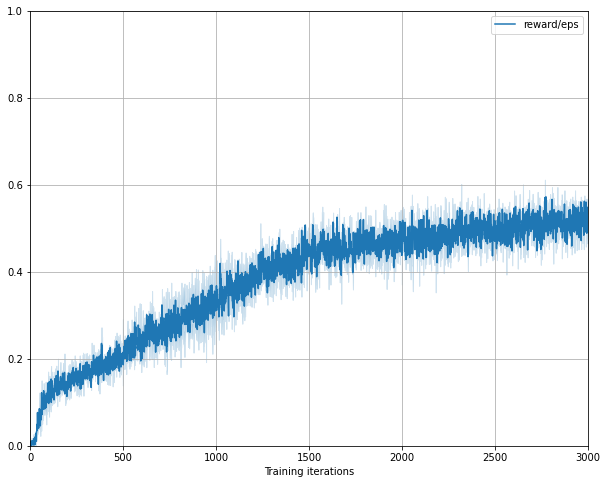

Total reward: 0.73
Total length: 15


Total reward: 0
Total length: 1


Total reward: 0.874
Total length: 7


In [28]:
plot_learning_curve(rewards, success_rates, params.num_updates, plot_std=True)
for _ in range(3):
    log_policy_rollout(policy, params.env_name, pytorch_policy=True)

Training completed!


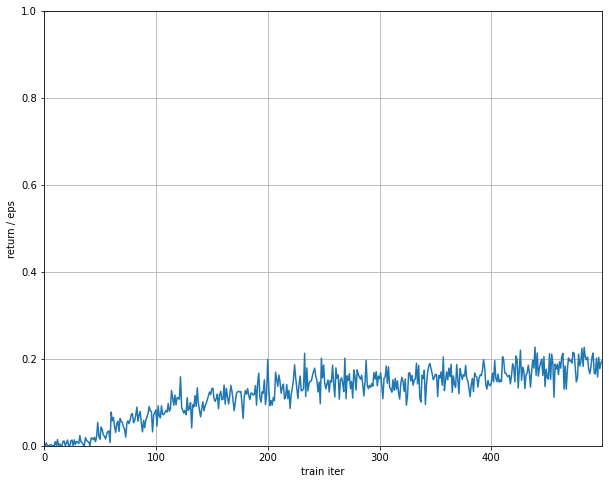

Total reward: 0.33399999999999996
Total length: 37


In [ ]:
# hyperparameters
policy_params = ParamDict(
    policy_class = Policy,    # Policy class to use (replaced later)     
    hidden_dim = 16,         # dimension of the hidden state in actor network
    learning_rate = 1e-3,     # learning rate of policy update
    batch_size = 1024,        # batch size for policy update
    policy_epochs = 4,        # number of epochs per policy update
    entropy_coef = 0.001,     # hyperparameter to vary the contribution of entropy loss
    #moreParams = True         # Model with more params for harder tasks
)
params = ParamDict(
    policy_params = policy_params,
    rollout_size = 2050,      # number of collected rollout steps per policy update
    num_updates = 500,         # number of training policy iterations
    discount = 0.99,          # discount factor
    plotting_iters = 10,      # interval for logging graphs and policy rollouts
    env_name = 'MiniGrid-LavaGapS6-v0',  # we are using a tiny environment here for testing
)

env, rollouts, policy = instantiate(params)
rewards, success_rate = train(env, rollouts, policy, params)
print("Training completed!")

# final reward + policy plotting for easier evaluation
plot_learning_curve(rewards, success_rate, params.num_updates)
for _ in range(1):
    log_policy_rollout(policy, params.env_name, pytorch_policy=True)

In [ ]:
# hyperparameters
policy_params = ParamDict(
    policy_class = Policy,    # Policy class to use (replaced later)     
    hidden_dim = 32,         # dimension of the hidden state in actor network
    learning_rate = 1e-3,     # learning rate of policy update
    batch_size = 1024,        # batch size for policy update
    policy_epochs = 4,        # number of epochs per policy update
    entropy_coef = 0.001,     # hyperparameter to vary the contribution of entropy loss
    #moreParams = True         # Model with more params for harder tasks
)
params = ParamDict(
    policy_params = policy_params,
    rollout_size = 2050,      # number of collected rollout steps per policy update
    num_updates = 1000,         # number of training policy iterations
    discount = 0.99,          # discount factor
    plotting_iters = 10,      # interval for logging graphs and policy rollouts
    env_name = 'MiniGrid-LavaGapS7-v0',  # we are using a tiny environment here for testing
)

env, rollouts, policy = instantiate(params)
rewards, success_rate = train(env, rollouts, policy, params)
print("Training completed!")

# final reward + policy plotting for easier evaluation
plot_learning_curve(rewards, success_rate, params.num_updates)
for _ in range(1):
    log_policy_rollout(policy, params.env_name, pytorch_policy=True)

In [ ]:
# hyperparameters
policy_params = ParamDict(
    policy_class = Policy,    # Policy class to use (replaced later)     
    hidden_dim = 64,         # dimension of the hidden state in actor network
    learning_rate = 1e-3,     # learning rate of policy update
    batch_size = 1024,        # batch size for policy update
    policy_epochs = 4,        # number of epochs per policy update
    entropy_coef = 0.001,     # hyperparameter to vary the contribution of entropy loss
    #moreParams = True         # Model with more params for harder tasks
)
params = ParamDict(
    policy_params = policy_params,
    rollout_size = 2050,      # number of collected rollout steps per policy update
    num_updates = 10000,         # number of training policy iterations
    discount = 0.99,          # discount factor
    plotting_iters = 500,      # interval for logging graphs and policy rollouts
    env_name = 'MiniGrid-Dynamic-Obstacles-8x8-v0',  # we are using a tiny environment here for testing
)

env, rollouts, policy = instantiate(params)
rewards, success_rate = train(env, rollouts, policy, params)
print("Training completed!")

# final reward + policy plotting for easier evaluation
plot_learning_curve(rewards, success_rate, params.num_updates)
for _ in range(1):
    log_policy_rollout(policy, params.env_name, pytorch_policy=True)

Training model with 11331 parameters...
it 0: avgR: -0.991 -- rollout_time: 3.745sec -- update_time: 0.110sec
it 1: avgR: -0.989 -- rollout_time: 3.694sec -- update_time: 0.071sec
it 2: avgR: -0.895 -- rollout_time: 3.637sec -- update_time: 0.060sec
it 3: avgR: -0.809 -- rollout_time: 3.594sec -- update_time: 0.054sec
it 4: avgR: -0.600 -- rollout_time: 3.574sec -- update_time: 0.051sec
it 5: avgR: -0.267 -- rollout_time: 3.547sec -- update_time: 0.049sec
it 6: avgR: -0.140 -- rollout_time: 3.524sec -- update_time: 0.048sec
it 7: avgR: -0.048 -- rollout_time: 3.514sec -- update_time: 0.047sec
it 8: avgR: 0.000 -- rollout_time: 3.488sec -- update_time: 0.048sec
it 9: avgR: 0.000 -- rollout_time: 3.446sec -- update_time: 0.049sec
it 10: avgR: 0.000 -- rollout_time: 3.412sec -- update_time: 0.049sec
it 11: avgR: -0.024 -- rollout_time: 3.375sec -- update_time: 0.049sec
it 12: avgR: 0.000 -- rollout_time: 3.348sec -- update_time: 0.049sec
it 13: avgR: 0.000 -- rollout_time: 3.327sec -- upd

it 501: avgR: 0.000 -- rollout_time: 3.061sec -- update_time: 0.060sec
it 502: avgR: 0.000 -- rollout_time: 3.061sec -- update_time: 0.060sec
it 503: avgR: 0.000 -- rollout_time: 3.061sec -- update_time: 0.060sec
it 504: avgR: 0.000 -- rollout_time: 3.061sec -- update_time: 0.060sec
it 505: avgR: 0.000 -- rollout_time: 3.062sec -- update_time: 0.060sec
it 506: avgR: 0.000 -- rollout_time: 3.062sec -- update_time: 0.061sec
it 507: avgR: 0.000 -- rollout_time: 3.062sec -- update_time: 0.061sec
it 508: avgR: 0.000 -- rollout_time: 3.063sec -- update_time: 0.061sec
it 509: avgR: 0.000 -- rollout_time: 3.063sec -- update_time: 0.061sec
it 510: avgR: 0.000 -- rollout_time: 3.063sec -- update_time: 0.061sec
it 511: avgR: 0.000 -- rollout_time: 3.063sec -- update_time: 0.061sec
it 512: avgR: 0.000 -- rollout_time: 3.063sec -- update_time: 0.061sec
it 513: avgR: 0.000 -- rollout_time: 3.064sec -- update_time: 0.061sec
it 514: avgR: 0.000 -- rollout_time: 3.064sec -- update_time: 0.061sec
it 515

it 1001: avgR: 0.000 -- rollout_time: 3.076sec -- update_time: 0.069sec
it 1002: avgR: 0.000 -- rollout_time: 3.076sec -- update_time: 0.069sec
it 1003: avgR: 0.000 -- rollout_time: 3.076sec -- update_time: 0.069sec
it 1004: avgR: 0.000 -- rollout_time: 3.076sec -- update_time: 0.069sec
it 1005: avgR: 0.000 -- rollout_time: 3.076sec -- update_time: 0.069sec
it 1006: avgR: 0.000 -- rollout_time: 3.076sec -- update_time: 0.069sec
it 1007: avgR: 0.000 -- rollout_time: 3.076sec -- update_time: 0.069sec
it 1008: avgR: 0.000 -- rollout_time: 3.076sec -- update_time: 0.069sec
it 1009: avgR: 0.000 -- rollout_time: 3.076sec -- update_time: 0.069sec
it 1010: avgR: 0.000 -- rollout_time: 3.076sec -- update_time: 0.069sec
it 1011: avgR: 0.000 -- rollout_time: 3.076sec -- update_time: 0.069sec
it 1012: avgR: 0.000 -- rollout_time: 3.076sec -- update_time: 0.069sec
it 1013: avgR: 0.000 -- rollout_time: 3.076sec -- update_time: 0.069sec
it 1014: avgR: 0.000 -- rollout_time: 3.076sec -- update_time: 0

it 1501: avgR: 0.000 -- rollout_time: 3.077sec -- update_time: 0.072sec
it 1502: avgR: 0.000 -- rollout_time: 3.077sec -- update_time: 0.072sec
it 1503: avgR: 0.000 -- rollout_time: 3.077sec -- update_time: 0.072sec
it 1504: avgR: 0.000 -- rollout_time: 3.077sec -- update_time: 0.072sec
it 1505: avgR: 0.000 -- rollout_time: 3.077sec -- update_time: 0.072sec
it 1506: avgR: 0.000 -- rollout_time: 3.077sec -- update_time: 0.072sec
it 1507: avgR: 0.000 -- rollout_time: 3.077sec -- update_time: 0.072sec
it 1508: avgR: 0.000 -- rollout_time: 3.077sec -- update_time: 0.072sec
it 1509: avgR: 0.000 -- rollout_time: 3.077sec -- update_time: 0.072sec
it 1510: avgR: 0.000 -- rollout_time: 3.077sec -- update_time: 0.072sec
it 1511: avgR: 0.000 -- rollout_time: 3.077sec -- update_time: 0.072sec
it 1512: avgR: 0.000 -- rollout_time: 3.077sec -- update_time: 0.072sec
it 1513: avgR: 0.000 -- rollout_time: 3.077sec -- update_time: 0.072sec
it 1514: avgR: 0.000 -- rollout_time: 3.077sec -- update_time: 0

it 2001: avgR: 0.000 -- rollout_time: 3.082sec -- update_time: 0.073sec
it 2002: avgR: 0.000 -- rollout_time: 3.082sec -- update_time: 0.073sec
it 2003: avgR: 0.000 -- rollout_time: 3.082sec -- update_time: 0.073sec
it 2004: avgR: 0.000 -- rollout_time: 3.082sec -- update_time: 0.073sec
it 2005: avgR: 0.000 -- rollout_time: 3.082sec -- update_time: 0.073sec
it 2006: avgR: 0.000 -- rollout_time: 3.081sec -- update_time: 0.073sec
it 2007: avgR: 0.000 -- rollout_time: 3.081sec -- update_time: 0.073sec
it 2008: avgR: 0.000 -- rollout_time: 3.081sec -- update_time: 0.073sec
it 2009: avgR: 0.000 -- rollout_time: 3.081sec -- update_time: 0.073sec
it 2010: avgR: 0.000 -- rollout_time: 3.082sec -- update_time: 0.073sec
it 2011: avgR: 0.000 -- rollout_time: 3.082sec -- update_time: 0.073sec
it 2012: avgR: 0.000 -- rollout_time: 3.082sec -- update_time: 0.073sec
it 2013: avgR: 0.000 -- rollout_time: 3.082sec -- update_time: 0.073sec
it 2014: avgR: 0.000 -- rollout_time: 3.082sec -- update_time: 0

it 2501: avgR: 0.000 -- rollout_time: 3.080sec -- update_time: 0.074sec
it 2502: avgR: 0.000 -- rollout_time: 3.080sec -- update_time: 0.074sec
it 2503: avgR: 0.000 -- rollout_time: 3.080sec -- update_time: 0.074sec
it 2504: avgR: 0.000 -- rollout_time: 3.080sec -- update_time: 0.074sec
it 2505: avgR: 0.000 -- rollout_time: 3.080sec -- update_time: 0.074sec
it 2506: avgR: 0.000 -- rollout_time: 3.080sec -- update_time: 0.074sec
it 2507: avgR: 0.000 -- rollout_time: 3.080sec -- update_time: 0.074sec
it 2508: avgR: 0.000 -- rollout_time: 3.080sec -- update_time: 0.074sec
it 2509: avgR: 0.000 -- rollout_time: 3.080sec -- update_time: 0.074sec
it 2510: avgR: 0.000 -- rollout_time: 3.080sec -- update_time: 0.074sec
it 2511: avgR: 0.000 -- rollout_time: 3.080sec -- update_time: 0.074sec
it 2512: avgR: 0.000 -- rollout_time: 3.080sec -- update_time: 0.074sec
it 2513: avgR: 0.000 -- rollout_time: 3.080sec -- update_time: 0.074sec
it 2514: avgR: 0.000 -- rollout_time: 3.080sec -- update_time: 0